In [1]:
# imports
using DrWatson
@quickactivate "IEEE14"

using NonLinearSystemNeuralNetworkFMU
using ChainRulesCore
using Zygote
using BSON
using Flux
using LinearAlgebra
using FMI
using FMIImport

using Statistics
using Plots
using Metrics

import DataFrames
import CSV
import InvertedIndices
import StatsBase


using Random
import FMICore
using Libdl

include("utils.jl")
include("trainSupervised.jl")
include("trainUnsupervised.jl")
include("trainSemiSupervised.jl")

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.bin_to_cat :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.confusion_matrix :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.TFPN :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.binary_accuracy :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** increment

┌ Warning: Replacing docs for `Metrics.cohen_kappa :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.statsfromTFPN :: NTuple{4, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.classwise_stats_fn :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Warning: Replacing docs for `Metrics.global_stats :: Tuple{Any, Any}` in module `Metrics`
└ @ Base.Docs docs/Docs.jl:243


trainModelSemisupervised (generic function with 1 method)

Structure:
- data/fmu... loading
- 1. exp., clustered data
- data clustering
- results and learnings of 1. exp.
- 2. exp., unclustered data
- load unclustered data
- results and learnings of 2. exp.
- 3. exp., training time
- results and learnings of 3. exp.
- 4. exp., batchsize comparison (if not solved)
- results and learnings of 4. exp.

# introduction
- comparison between supervised training, unsupervised training and a combination for learning of SimpleLoop data.
- What is SimpleLoop?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/SimpleLoop

SimpleLoop describes a growing circle and a moving line and contains a non-linear system solving for the intersection points of the two objects.
$$r^2 = x^2 + y^2$$
$$rs + b = x + y$$
Inputs to the Surrogate are $r$ and $s$ and $b$ is a parameter.
Output of the Surrogate is $y$ and $x$ can be computed from $y$: $x = rs + b - y$

Supervised training:
- input output pairs: $\{(x_{1},y_{1}),...,(x_{N},\;y_{N})\}$
- Loss function MSE: $$L = \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2$$

Unsupervised Training:
- only input, no input output pairs: $\{x_{1},...,x_{N}\}$
- Loss function is measuring residual of output, should be $0$ at solution: $$L = \sum_i R(f(x_i ; \theta))$$

Semi-Supervised Training:
- input output pairs
- Loss function is combining MSE and residual: $$L = \sum_i \alpha_0 \big( f(x_i ; \theta)-y^*_i \big)^2 + \alpha_1 R(x_i)$$
- hyperparameters for weighting with: $\alpha_0 + \alpha_1 = 1$

Clustering:
- is applied to output data
- idea is to identify unique solutions in data and train on these solutions separately

In [2]:
# data loading into 
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/data/eq_14.csv"
nInputs = 2
nOutputs = 1

comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu("/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/simpleLoop.interface.fmu",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/profilingInfo.bson",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/temp-profiling/simpleLoop.c")

(FMU:            simpleLoop
InstanceName:   simpleLoop
Address:        Ptr{Nothing} @0x0000000003a1bfe0
State:          2
Logging:        0
FMU time:       0.0
FMU states:     nothing, Model name:	simpleLoop
Type:		0, ProfilingInfo[ProfilingInfo(EqInfo(14, 2512, 0.000317798, 1.5827e-5, 0.06756972823105675), ["y"], [11], ["s", "r"], NonLinearSystemNeuralNetworkFMU.MinMaxBoundaryValues{Float64}([0.0, 0.95], [1.4087228258248679, 3.15]))], UInt32[0x00000004], UInt32[0x00000001, 0x00000000], 14, 1)

# explanation of 1. experiment
- output data is clustered and then all approaches are trained
- then test mse and test residual is compared and xy plot

In [4]:
# preparation of 1. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)  

# concat in and out data
in_data = hcat(train_in, test_in)
out_data = hcat(train_out, test_out)

x = compute_x_from_y.(in_data[1,:], in_data[2,:], out_data[1,:])
out_data = hcat(x, out_data')'
# cluster out data
cluster_indices, num_clusters = cluster_data(out_data)
# extract cluster
cluster_index = 1
in_data = extract_cluster(in_data, cluster_indices, cluster_index)
out_data = extract_cluster(out_data, cluster_indices, cluster_index)
out_data = out_data[2,:]
out_data = reshape(out_data, 1, length(out_data))
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
# min max scaling
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

100

In [5]:
# 1. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.005772305389908565, 0.0017862199179760972, 0.0006924800230108109, 0.00035479161567105534, 0.00029816321590965924, 0.00022347585514887906, 0.0001622142332522079, 0.00014584404824759874, 0.0001519242145505216, 0.00011810310256400058  …  1.0959190763411501e-5, 9.588197245106192e-5, 9.060645578597904e-6, 1.9031053275716027e-5, 1.28142183346538e-5, 8.082984306990192e-6, 1.7384968784782117e-5, 1.2132120717438145e-5, 1.0551024805731951e-5, 2.3791774108169526e-5], 5.395673990249634)

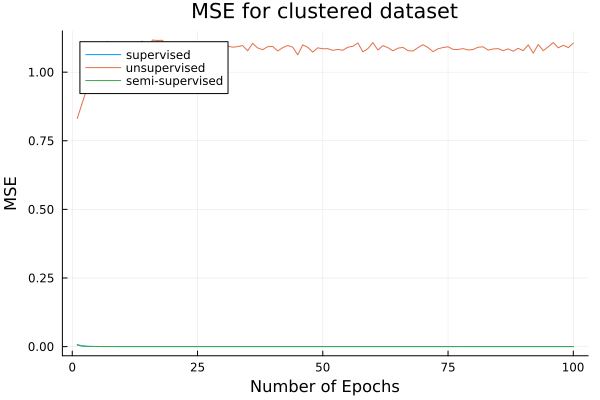

In [6]:
# results of 1. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

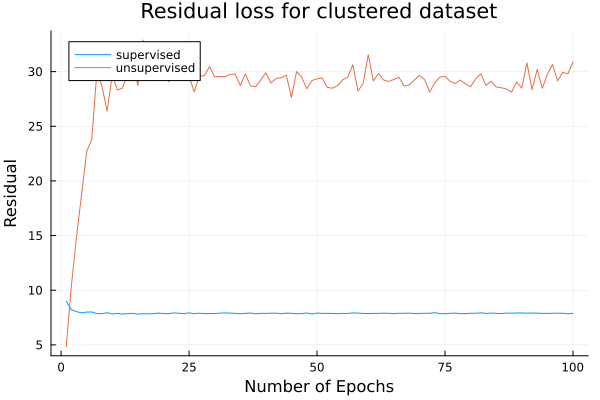

In [7]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual loss for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

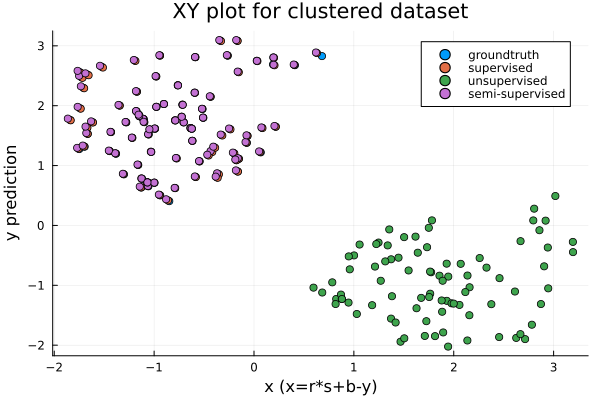

In [8]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth") # reconstruct
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for clustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# learnings of 1. experiment
- unsupervised training can converge to a true solution
- purely unsupervised is also unguided (random to which solution the net converges)
- only superior to supervised when clustering is not available: more compute while training, unguided
- semi-supervised is an option, when a preferred solution exists: less data generation, guiding of unsupervised training

# explanation of 2. experiment
- no clustering done, rest stays the same

In [9]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true) #???

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

100

In [10]:
# 2. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.12470586f0, 0.11657534f0, 0.11685313f0, 0.112333775f0, 0.12031725f0, 0.11729118f0, 0.117828086f0, 0.1157358f0, 0.11253074f0, 0.10869748f0  …  0.101358555f0, 0.104601584f0, 0.10687345f0, 0.105488084f0, 0.10371171f0, 0.10601225f0, 0.10749523f0, 0.108461335f0, 0.10679477f0, 0.1028207f0], 18.060648202896118)

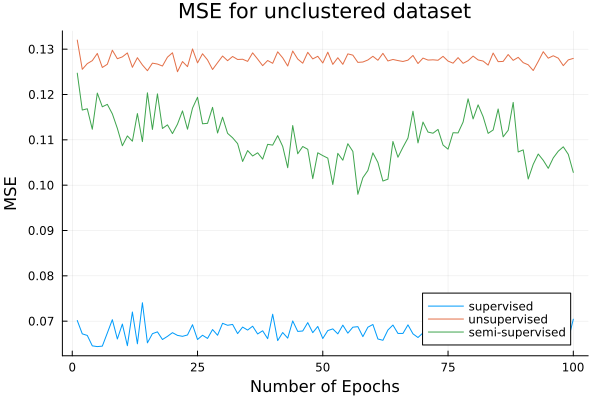

In [11]:
# results of 2. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

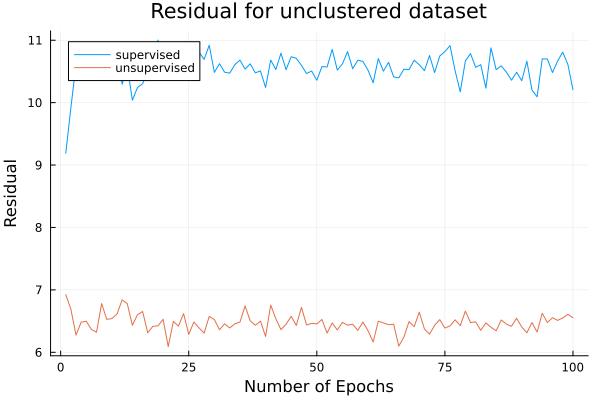

In [12]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

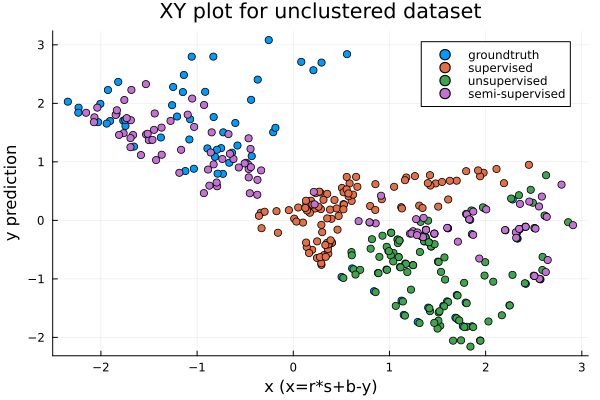

In [13]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# learnings of 2. experiment
- supervised cant converge on ambigous data
- unsupervised can
- semi-supervised needs tuning to converge or, cant converge
- loss values can be misleading

# explanation of 3. experiment
- comparing training time in epoch range

In [14]:
# preparation of 3. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)

epoch_range = [10,100,1000]
gen_unsupervised_data_time = 0.05 # seconds for 1000 datapoints
gen_supervised_data_time = 25 # seconds for 1000 datapoints

25

In [15]:
# 3. experiment unsupervised
full_unsupervised_test_loss_hist = []
full_res_unsupervised_test_loss_hist = []
full_unsupervised_train_time_hist = []
for n_epochs in epoch_range
  unsupervised_model, unsupervised_test_loss_hist, res_unsupervised_test_loss_hist,  unsupervised_time = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=n_epochs
    )
    push!(full_unsupervised_test_loss_hist, unsupervised_test_loss_hist[end])
    push!(full_res_unsupervised_test_loss_hist, res_unsupervised_test_loss_hist[end])
    push!(full_unsupervised_train_time_hist, unsupervised_time)
end

In [16]:
# 3. experiment supervised
full_supervised_test_loss_hist = []
full_res_supervised_test_loss_hist = []
full_supervised_train_time_hist = []
for n_epochs in epoch_range
  supervised_model, supervised_test_loss_hist, res_supervised_test_loss_hist, supervised_time = trainModelSupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu;epochs=n_epochs
    )
    push!(full_supervised_test_loss_hist, supervised_test_loss_hist[end])
    push!(full_res_supervised_test_loss_hist, res_supervised_test_loss_hist[end])
    push!(full_supervised_train_time_hist, supervised_time)
end

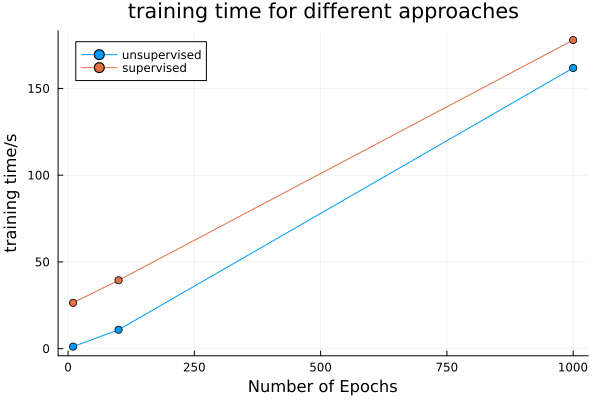

In [17]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist .+ gen_unsupervised_data_time, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist .+ gen_supervised_data_time, epoch_range; label="supervised", marker = :circle)
title!("training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("training time/s")

# learnings of 3.experiment
- training time increases linearly with number of epochs
- unsupervised data generation is ~500 times faster than supervised data generation

# explanation of 4. experiment
- comparing batchsize 1 vs 8

In [18]:
# preparation of 4. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader_1 = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)
dataloader_8 = Flux.DataLoader((train_in, train_out), batchsize=16, shuffle=true)

hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
opt = Flux.Adam(1e-4)
epochs = 100

Adam(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [19]:
# 4. experiment
unsupervised_model_1, unsupervised_test_loss_hist_1, res_unsupervised_test_loss_hist_1,  unsupervised_time_1 = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader_1, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
    )

unsupervised_model_8, unsupervised_test_loss_hist_8, res_unsupervised_test_loss_hist_8,  unsupervised_time_8 = trainModelUnsupervised(
  deepcopy(model), deepcopy(opt), dataloader_8, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
  )

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.22092603f0, 0.1267864f0, 0.099947825f0, 0.09123662f0, 0.08002122f0, 0.07356585f0, 0.07285175f0, 0.07257151f0, 0.07276949f0, 0.07066566f0  …  0.06010309f0, 0.06208928f0, 0.06816346f0, 0.07339612f0, 0.07196034f0, 0.07161831f0, 0.07135358f0, 0.07258366f0, 0.06655659f0, 0.06424984f0], Any[64.47873176419718, 13.82482571873159, 6.628801530106106, 5.043018962856116, 3.5173195730642637, 2.9049114021805935, 2.845137586246139, 2.8594163087475737, 2.8648944349937744, 2.7668536427901063  …  2.8217463195964556, 2.936239197061257, 3.5253802072757874, 4.118742589677572, 3.9774721030450397, 3.9729321887216305, 3.901760097526372, 4.035433283199833, 3.247521815167051, 3.0683766717027994], 1.4631896018981934)

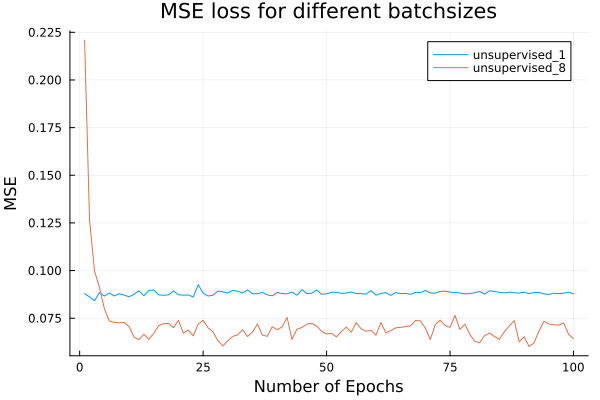

In [20]:
# results of 4. experiment
plot_loss_history(unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("MSE loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("MSE")

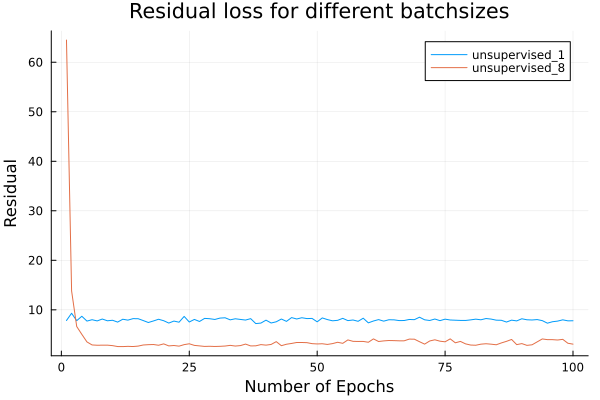

In [21]:
plot_loss_history(res_unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(res_unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("Residual loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("Residual")

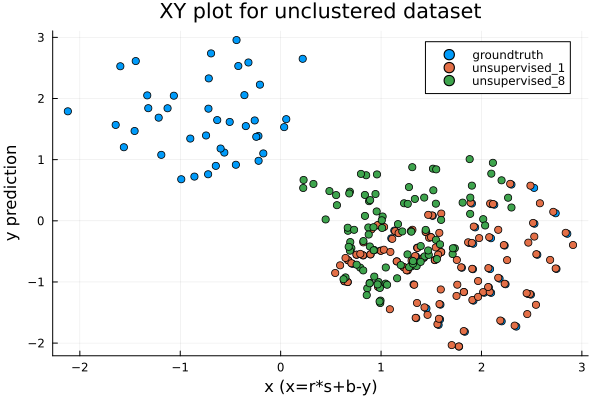

In [22]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(unsupervised_model_1, test_in, test_out, test_in_t, test_out_t; label="unsupervised_1")
plot_xy(unsupervised_model_8, test_in, test_out, test_in_t, test_out_t; label="unsupervised_8")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# learnings of 4. experiment
- unsupervised is useless cause bigger batchsize leads to problems

In [ ]:
# IEEE14 residual


# results/conclusion of whole notebook